# **Coursework 1: Train a Sentiment Analysis Classifier**
In this course work, you are asked to train a sentiment analysis classifier for movie reviews. The sample code below builds a simple classifier that uses tf-idf to vectorize text and a logistic regression model to make predictions.

## **Table of Contents**

 1. [Introduction](#1)


 2. [Cleaning](#2)  
 
      i. [Removing Punctuations](#2a)  
      ii [Removing Stop Words](#2b)  


 3. [Normalizing](#3)  
 
    ii. [Stemming](#3a)  
    iii. [Lemmatization](#3b)  


 4. [Initial Analysis](#4)  
 
 

 5. [Vectorizer](#5)
 
     i. [Train-Text Split](#5a)  
     ii. [Tf-Idf Vectorizer](#5b)


 6. [Feature Engineering](#6)  


 7. [Final Model Build](#7)

<a id="1"></a>
## **1. Introduction**

This purpose of this assignment is to build a sentiment analysis classifier for movie reviews, which can take a piece of movie review as input and predicts the overall sentiment (positive or negative). This report explains the analysis of the dataset, the feature seleections method and final model building procedure using one of many algorithms. The overall process is implemented in Python.

In [1]:
# Initital imports required for this Courserwork
import numpy as np
import pandas as pd
import random
random.seed(123518)
import re
import pickle
import string
import nltk
import spacy
import itertools

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support,accuracy_score
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from tqdm import trange, tqdm
tqdm.pandas()

After loading the *coursework1_train.csv* file initial overview shows us that there are 2 columns in the dataset.  


**text** column which is a review of a particular movie  
**sentiment** column which tells us that the corresponding review is a positive or a negative review.  
        
        'pos' --> positive review  
        'neg' --> negative review  

In [2]:
raw_data = pd.read_csv('coursework1_train.csv', index_col=0, dtype=str)
raw_data.head()

,text,sentiment
0,Enjoy the opening credits. They're the best th...,neg
1,"Well, the Sci-Fi channel keeps churning these ...",neg
2,It takes guts to make a movie on Gandhi in Ind...,pos
3,The Nest is really just another 'nature run am...,neg
4,Waco: Rules of Engagement does a very good job...,pos


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 2 columns):
text         40000 non-null object
sentiment    40000 non-null object
dtypes: object(2)
memory usage: 937.5+ KB


In [4]:
raw_data['sentiment'].value_counts().reset_index()

,index,sentiment
0,pos,20000
1,neg,20000


The dataset contains equal number of positive and negative sentiments i.e. 2000 examples for each.  
Looking at some random examples to understand the dataset

In [5]:
ri = [13378, 17961, 5729]

for i in range(len(ri)):
    print('Movie Review Number: {}'.format(ri[i]))
    print('-'*26)
    print(raw_data['text'][ri[i]])
    print('\n')

Movie Review Number: 13378
--------------------------
This extraordinary pseudo-documentary, made in 1971, perfectly captures the zeitgeist of America today...which makes it all the more scary and relevant. "subversives" (college students, hippies, black activists, academics) are being rounded up by the government and given lengthy prison terms for what amount to thought crimes and social protest. As an alternative to life in prison, these convicted "criminals" are offered three days in "Punishment Park". Their objective inside the park is to make their way to the American flag where freedom awaits them. Not surprisingly, the Punishment Park option is a dirty lie. This brilliant film from Peter Watkins even pre-dates "Battle Royale" and "Series 7", though its angle of attack is more blatantly political. Shot in '71, it looks and feels as fresh as anything made today. The performances are exemplary and the direction is razer sharp. The narrative cuts back and forth between various group

From the above 3 examples chosen at random, we can see that a review has mix of below combinations:   
 
* capitalized and lowercase words,<br/>*e.g.: "This extraordinary pseudo-documentary"*  
* there are words written in uppercase,<br/>*e.g.: 'PROBLEM', 'SLUG'*   
* certain proper nouns are written within quotes,<br/>*e.g.: "Vampire Asssasin", "Zombie Nation"*    
* different html tags are present,<br/>*e.g.: "< b r />*    
* basic punctuations<br/>*e.g.: ,.'?!*  
* other redundant symbols<br/>*e.g. */\  ...*   


The general approach of text processing are as follows:

- Cleaning
    - Removing Punctuations
    - Removing Stop Words
- Normalizing
    - Lower Casing
    - Stemming
    - Lemmatization

All the above process will be implemented and performance checked with respect to two algorithms.<br/>For the purpose of this coursework we are going to look into **Naive Bayes** and **Logistic Regression** only as they are one the classical classification algorithms and also effective.

<a id="2"></a>
## **2. Cleaning**
- The process of remove useless information from the text before starting analysis and modelling comes under the ***'Cleaning'*** step.
- In order to perform cleaning, first the text is to be ***tokenized***. Tokenization is the process of splitting sentences into their constituents, which are known as tokens. In English, tokens correspond to words and numeric sequences separated  by white-space characters or punctuation.
- There can 2 types of tokenization.
    - Scentence Tokenization
    - Word Tokenization
- In this dataset all the movie review are present in English and hence we are going to follow the word tokenization process where the text is split into tokens at white-space characters.


<a id="2a"></a>
### **i. Removing Punctuations**  

There can be several approaches to clean the text from unwanted symbols using regex.  
1. Iterate through the tokenize texts and apply the regex to substitute the punctuations and unwanted symbols with white-spaces.
2. Apply a regex pattern to extract only english alphabets from the bunch of text.

The first process is a time consuming process as it requires multiple number of iterations to implement it successfully. The second process is a much faster one as it can extract the texts from the whole corpus in much less time.  
In this coursework the second process is implemented.  

An example text showing the status of the text ***Before*** and ***After*** Cleaning process is shown below:

In [6]:
def regex_cleaner(text):
    cleaner = r"(\\)|(x\d\d)|(<br \/>)|( - )|( -- )|(\[)|(\])|(-)"
    text = re.sub(r'\.\.\.', ' ', text)
    text = re.sub(r'\.\.', ' ', text)
    text = re.sub(r' \. ', '. ', text)
    text = re.sub(r'\.', '. ', text)
    text = re.sub(cleaner, ' ' ,text)
    return text

def tokenize_text(text):
    nlp = spacy.load('en')
    doc = nlp(text)
    return [str(i) for i in doc]

def cleaner(text):
    
    doc = pd.Series(text.split())
    doc = doc[~doc.apply(str.lower).isin(list(string.punctuation))]
    doc = doc.apply(lambda x: re.sub(r'(,)|(:)|(!)|( )|(\()|(\))|(\")|(\?)',' ', x.strip().lower()))
    doc = doc.apply(lambda x: re.sub(r'(\')', '', x.strip().lower()))
    doc = doc[~doc.apply(str.lower).isin(list(string.punctuation))]
    doc = doc[~doc.apply(str.lower).isin([' ', '  ', '   '])]
    doc = doc.apply(lambda x: re.sub(' +', ' ', x))
    return ' '.join(list(doc))

def word_extract(text):
    text = re.findall(r'[A-Za-z]+[\w^\']*', text.lower())
    text = [i for i in text if i != 'br']
    return text

def sent_cleaner(text):
    doc = []
    for i in sent_tokenize(text):
        i = regex_cleaner(i)
        i = cleaner(i)
        doc.append(i)
    return ' '.join(doc)

def stem_words(text):
    p_stem = PorterStemmer()
    return [p_stem.stem(word=i) for i in text]

def lemmer(text):
    
    wordnet_lemmatizer = WordNetLemmatizer()
    doc = pd.Series(text)
    doc = doc.apply(wordnet_lemmatizer.lemmatize, args=('n'))
    doc = doc.apply(wordnet_lemmatizer.lemmatize, args=('v'))
    doc = doc.apply(wordnet_lemmatizer.lemmatize, args=('a'))
    
    return list(doc)
#--------------------------------------------------------------------------------------------------#
print('Before Cleaning')
print('-'*15)
print(raw_data['text'][83])
print('\n')
print('After Cleaning')
print('-'*15)
print(' '.join(word_extract(raw_data['text'][83])))

raw_data['cleaned'] = raw_data['text'].apply(word_extract)

Before Cleaning
---------------
Wow. I just saw Demon Wind a little while ago, and I don't think I'll ever be the same. It has the power to inspire nightmares, but for all the wrong reasons, actually.<br /><br />Never before has humanity seen such a gratuitous change in make-up, for no damn reason. Or, similarly, so much bad zombie (?) makeup that makes you hungry for those Halloween green marshmallows.<br /><br />Or so much naked old lady, for that matter. But then, there was "The Shining."<br /><br />The plot here is so amateurish that it actually almost holds a little bit of charm, as does the dialog. The last shot of the film is just so silly that its beyond description. It's like some drunk college student got together with some pals and decided to throw Bruce Willis type dialog together with (I guess?) teenybopper dialog from some Elm Street film. The result is jarring, and it'd be truly funny if it was intended that way.<br /><br />Ah, what the hey. I'll laugh anyway.<br /><br /

- All the words are extracted successfully without the punctuations. Combined words like *I'll, don't, it's* etc. are also extracted keeping the apostrophe.  
- All the text is also converted into lowercase to avoid duplicate vocabulary in our corpus.

<a id="2b"></a>
### **ii. Removing Stop Words**
There are a several libraries which provides a corpus of ***Stop-Words***. NLTK and Spacy are one of the most popular ones.  
Below are the features of the NLTK and Spacy stopwords.

In [7]:
print('Number of Stop-Words present in the NLTK stopwords list: {}'.format(len(stopwords.words('english'))))
print('Number of Stop-Words present in the Spacy stopwords list: {}'.format(len(STOP_WORDS)))

Number of Stop-Words present in the NLTK stopwords list: 179
Number of Stop-Words present in the Spacy stopwords list: 326


As the purpose of the coursework is analyzing the sentiment of the review sometimes it can be necessary to remove a few stop-words or not to remove the stopwords at all.  
For our case, both the stop-words corpus will be implemented and evaluated in order to measure the performance.

In [8]:
def sw_remover(text, nltk=True, spacy=False):
    nltk_sw = stopwords.words('english')
    spacy_sw = STOP_WORDS
    if nltk:
        text = [i for i in text if i not in nltk_sw]
        return text
    elif spacy:
        text = [i for i in text if i not in spacy_sw]
        return text

In [9]:
print('Before Stop-Words removal review size {}:'.format(len(raw_data['cleaned'][0])))
print('-'*42)
print(' '.join(raw_data['cleaned'][0]))

Before Stop-Words removal review size 287:
------------------------------------------
enjoy the opening credits they're the best thing about this second rate but inoffensive time killer which features passable performances from the likes of eric roberts and martin kove the main part however goes to newcomer tommy lee thomas who looks a bit diminutive for this kind of action but who nevertheless occasionally manages to project a banty rooster kind of belligerence the first time we see him he's bare chested sweaty and engaged in that favorite beefcake activity chopping wood after this he has seven more scenes without his shirt including one in which he's hanged by his wrists and zapped with electricity a la mel gibson in lethal weapon he could use a better script however since the manner in which he exposes the truth about corruption and violence inside the prison is never very convincing there's also talk about millions of dollars which apparently is tied in with this investigation but 

In [10]:
z = sw_remover(raw_data['cleaned'][0], nltk=True, spacy=False)
print('After NLTK Stop-Words removal review size {}:'.format(len(z)))
print('-'*47)
print(' '.join(z))

After NLTK Stop-Words removal review size 171:
-----------------------------------------------
enjoy opening credits they're best thing second rate inoffensive time killer features passable performances likes eric roberts martin kove main part however goes newcomer tommy lee thomas looks bit diminutive kind action nevertheless occasionally manages project banty rooster kind belligerence first time see he's bare chested sweaty engaged favorite beefcake activity chopping wood seven scenes without shirt including one he's hanged wrists zapped electricity la mel gibson lethal weapon could use better script however since manner exposes truth corruption violence inside prison never convincing there's also talk millions dollars apparently tied investigation never explained pluses though sending john woodrow undercover john wilson amusing play presidential name co star jody ross nolan shows promise inmate early proceedings shown hanged wrists getting punched burly guard one final note movie's 

In [11]:
z = sw_remover(raw_data['cleaned'][0], nltk=False, spacy=True)
print('After Spacy Stop-Words removal review size {}:'.format(len(z)))
print('-'*47)
print(' '.join(z))

After Spacy Stop-Words removal review size 155:
-----------------------------------------------
enjoy opening credits they're best thing second rate inoffensive time killer features passable performances likes eric roberts martin kove main goes newcomer tommy lee thomas looks bit diminutive kind action occasionally manages project banty rooster kind belligerence time he's bare chested sweaty engaged favorite beefcake activity chopping wood seven scenes shirt including he's hanged wrists zapped electricity la mel gibson lethal weapon use better script manner exposes truth corruption violence inside prison convincing there's talk millions dollars apparently tied investigation explained pluses sending john woodrow undercover john wilson amusing play presidential co star jody ross nolan shows promise inmate early proceedings shown hanged wrists getting punched burly guard final note movie's low budget painfully responsible lack extras despite impressive size prison hold inmates note cast c

In [10]:
raw_data['cleaned_nltk_sw'] = raw_data['cleaned'].apply(sw_remover, args=(True, False))
raw_data['cleaned_spacy_sw'] = raw_data['cleaned'].apply(sw_remover, args=(False, True))


We can see that number of words remaining after implementing stop-words removal using Spacy stopwords is comparatively less than that after removal of NLTK. We'll analyze the impact in the next sections.

<a id="3"></a>
## **3. Normalizing**

The process of converting all the texts inthe corpus into it's true root form is text normalization. It is not always necessary to perform text normalization.  
When we are performing sentiment analysis on a large corpus of data performing text normalization will reduce our feature space but can affect the overall performance of the algorithm.  
Both the type of most popular text processing will be implemented and based on the performance the algorithms we'll decide if we need to use text normalization or not.

<a id="3a"></a>
### **i. Stemming**

The process of reducing words to their root forms such as mapping a group of words to the same stem even if  the stem itself is not a valid word in the Language.

In [11]:
raw_data['cleaned_nltk_sw_stemmed'] = raw_data['cleaned_nltk_sw'].apply(stem_words)
raw_data['cleaned_spacy_sw_stemmed'] = raw_data['cleaned_spacy_sw'].apply(stem_words)

From the below table we can see a before and after effect of stemming.

| Before Stemming |     | After Stemming | 
| :--------       | | :--------   | 
| discussion | |discuss |
| times | | time |
| named | | name |
| films | | film |
| saving | | save |
| outstanding | | outstand |
| technical | | technic |
| message | | messag |
| entertaining | | entertain |
| movie | | movi |
| combines | | combin |
| shooting | | shoot |

For example, words like outstanding, technical, message are converted to outstand, technic, messag respectively. The root forms are not an actual word which exists in the English language.

<a id="3b"></a>
### **ii. Lemmatization**
Lemmatization process reduces the inflected words properly ensuring that the root word belongs to the language.  
This is a much more costlier process than Stemming as it checks the parts-of-speech of the token and then converts it into it's root form based on the mentioned part-of-speech. It can be either a verb root form, a noun root form or an adjective root form.

In [12]:
raw_data['cleaned_nltk_sw_lemm'] = raw_data['cleaned_nltk_sw'].apply(lemmer)
raw_data['cleaned_spacy_sw_lemm'] = raw_data['cleaned_spacy_sw'].apply(lemmer)

The below table shows a before and after situation after implementing Lemmatization. 


| Before Lemmatization |     | After Lemmatization | 
| :--------       | | :--------   | 
| greatest | | great
| times | | time
| named | | name
| greatest | | great
| films | | film
| saving | | save
| entertaining | | entertain
| combines | | combine
| shooting | | shoot
| things | | thing
| starting | | start
| civilizations | | civilization
| wartimes | | wartime
| says | | say

From the above table we can see superlative adjectives are converted into their positive root, plurals are converted into their singular form and continuous nouns/verbs are converted into normal noun form.

<a id="4"></a>
## **4. Initial Analysis**  
 
In order to understand the data present at hand we need to perform some basic exploratory analysis. The two types of analysis we are going to perform are as follows:
- *Frequency Analysis*
- *Parts of Speech Analysis*

Both types of analysis will be performed class-wise i.e. with respect to each class label.

<a id="4a"></a>
### **i. Frequency Analysis**

The below 2 bar plots shows us the most occuring words present in the words present in the positive and negative reviews respectively.

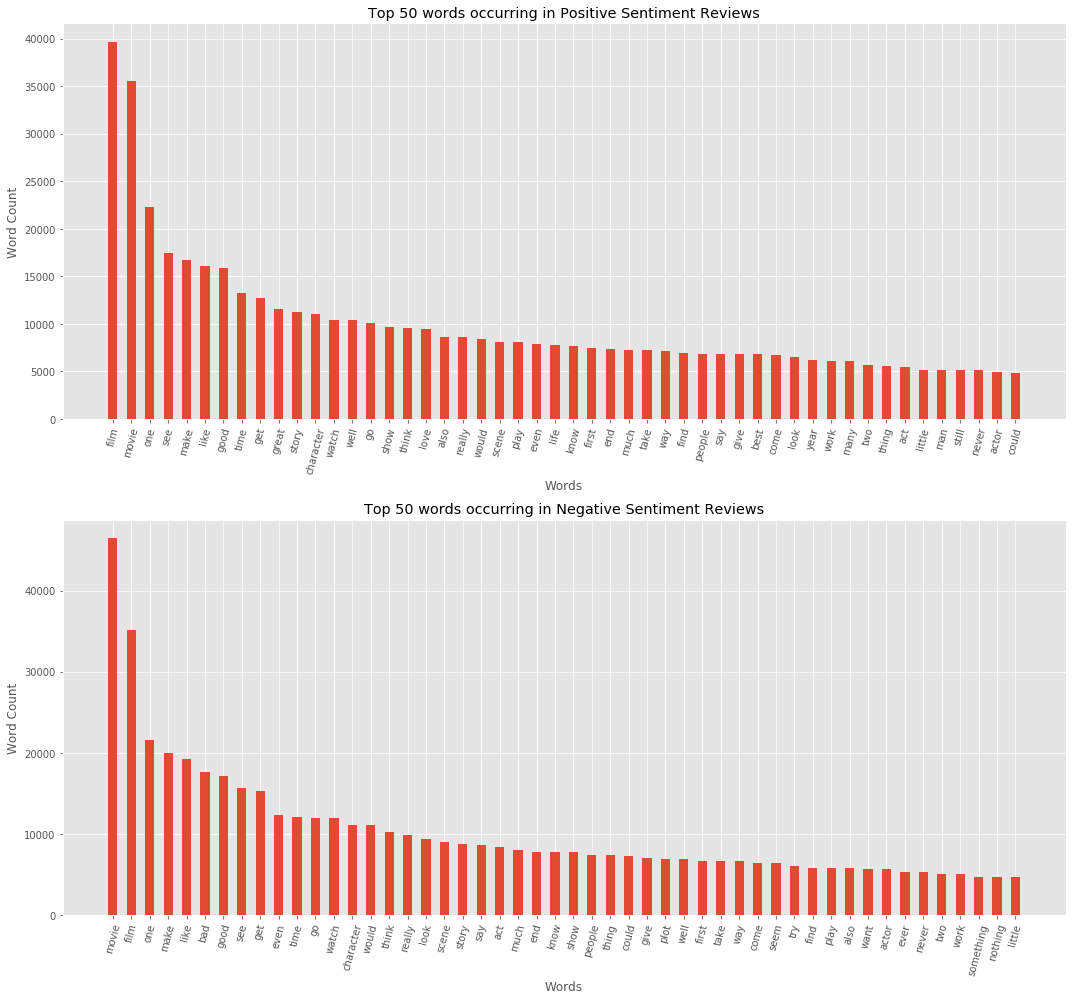

In [13]:
pos_words = list(itertools.chain.from_iterable(raw_data[raw_data['sentiment'] == 'pos']['cleaned_nltk_sw_lemm']))
neg_words = list(itertools.chain.from_iterable(raw_data[raw_data['sentiment'] == 'neg']['cleaned_nltk_sw_lemm']))

pos_fd = FreqDist(pos_words)
neg_fd = FreqDist(neg_words)

pos = pd.DataFrame.from_dict(pos_fd, orient='index', columns=['count']).sort_values('count', ascending=False)

neg = pd.DataFrame.from_dict(neg_fd, orient='index', columns=['count']).sort_values('count', ascending=False)

plt.figure(figsize=(15, 14))
plt.subplot(2, 1, 1)
plt.bar(height=pos.head(50)['count'], x=np.arange(50), width=0.5)
plt.xticks(ticks=(np.arange(50)), labels=(pos.head(50).index), rotation=75)
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('Top 50 words occurring in Positive Sentiment Reviews')

plt.subplot(2, 1, 2)
plt.bar(height=neg.head(50)['count'], x=np.arange(50), width=0.5)
plt.xticks(ticks=(np.arange(50)), labels=(neg.head(50).index), rotation=75)
plt.xlabel('Words')
plt.ylabel('Word Count')
plt.title('Top 50 words occurring in Negative Sentiment Reviews')

plt.tight_layout()
plt.show();

We can see that there are multiple common words present in both the types of reviews. Let's observe the distribution by removing the common words from both the review set.

In [14]:
pos.reset_index(inplace=True)
neg.reset_index(inplace=True)
sw = pd.merge(pos, neg, how='inner', on='index')['index'].tolist()
pos_words = pd.DataFrame(pos_words, columns=['words'])
pos_words = pos_words[~pos_words['words'].isin(sw[50:])]['words'].apply(lambda x: x.strip()).tolist()
neg_words = pd.DataFrame(neg_words, columns=['words'])
neg_words = neg_words[~neg_words['words'].isin(sw[50:])]['words'].apply(lambda x: x.strip()).tolist()

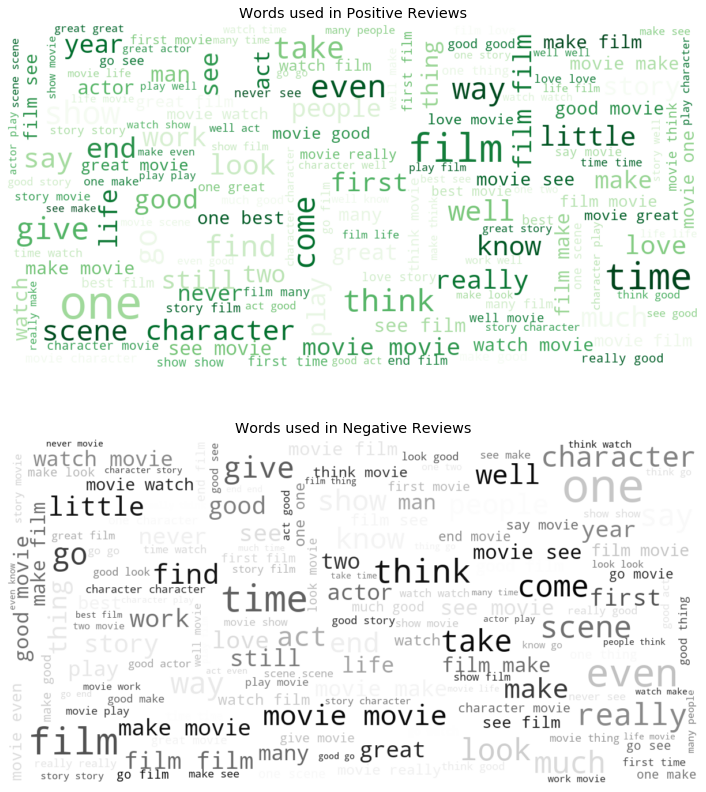

<Figure size 432x288 with 0 Axes>

In [15]:
wordcloud = WordCloud(max_font_size=80, max_words=150, width=1200, height=600, colormap='Greens', background_color="white").generate(' '.join(pos_words))
plt.figure(figsize=(20, 14))
plt.subplot(2, 1, 1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Words used in Positive Reviews')
wordcloud = WordCloud(max_font_size=80, max_words=150,  width=1200, height=600, colormap='Greys', background_color="white").generate(' '.join(neg_words))
plt.subplot(2, 1, 2)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Words used in Negative Reviews')
plt.show()
plt.tight_layout();

We observe the words which are present in either sentiment groups and not present in the top 50 common words between them.
From the above set of word-clouds we can see that there are a few common words which are still prominent, but there are quite a few words which are significant to each sentiment group.

<a id="5"></a>
## **5. Vectorizer**

<a id="5a"></a>
## **i. Train-Text Split**


- The data-set is divided into a train and dev-test set, with 80% of the data in train and 20% of the data in dev-test.  
- We have 40000 documents in the dataset, 35000 is moved into train set and the remaining 5000 is considered as dev-test set.  
- The index of 35000 numbers are randomly generated between 0 and 40000. 
- The remaining indexes which are not present in the generated indexes are considered as the test set.

Below is a set of results which shows us the training and dev-test performance of Logistic Regression and Gaussian Naive Bayes algorithm on 7 different types of processed data with maximum 10,000 features generated using tf-idf vectorizer.  


In [16]:
s = random.sample(range(0, 40000), k=35000)

train_text = raw_data.iloc[s,]['cleaned'].apply(lambda x: ' '.join(x))
train_text_nltk_sw = raw_data.iloc[s,]['cleaned_nltk_sw'].apply(lambda x: ' '.join(x))
train_text_spacy_sw = raw_data.iloc[s,]['cleaned_spacy_sw'].apply(lambda x: ' '.join(x))
train_text_nltk_sw_stemmed = raw_data.iloc[s,]['cleaned_nltk_sw_stemmed'].apply(lambda x: ' '.join(x))
train_text_spacy_sw_stemmed = raw_data.iloc[s,]['cleaned_spacy_sw_stemmed'].apply(lambda x: ' '.join(x))
train_text_nltk_sw_lemm = raw_data.iloc[s,]['cleaned_nltk_sw_lemm'].apply(lambda x: ' '.join(x))
train_text_spacy_sw_lemm = raw_data.iloc[s,]['cleaned_spacy_sw_lemm'].apply(lambda x: ' '.join(x))

test_text = raw_data[~raw_data.index.isin(s)]['cleaned'].apply(lambda x: ' '.join(x))
test_text_nltk_sw = raw_data[~raw_data.index.isin(s)]['cleaned_nltk_sw'].apply(lambda x: ' '.join(x))
test_text_spacy_sw = raw_data[~raw_data.index.isin(s)]['cleaned_spacy_sw'].apply(lambda x: ' '.join(x))
test_text_nltk_sw_stemmed = raw_data[~raw_data.index.isin(s)]['cleaned_nltk_sw_stemmed'].apply(lambda x: ' '.join(x))
test_text_spacy_sw_stemmed = raw_data[~raw_data.index.isin(s)]['cleaned_spacy_sw_stemmed'].apply(lambda x: ' '.join(x))
test_text_nltk_sw_lemm = raw_data[~raw_data.index.isin(s)]['cleaned_nltk_sw_lemm'].apply(lambda x: ' '.join(x))
test_text_spacy_sw_lemm = raw_data[~raw_data.index.isin(s)]['cleaned_spacy_sw_lemm'].apply(lambda x: ' '.join(x))

train_labels = raw_data.iloc[s,]['sentiment']
test_labels = raw_data[~raw_data.index.isin(s)]['sentiment']

print('Training and Testing on only cleaned data set..')
print('*'*50)

max_feature_num = 10000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, lowercase=True, sublinear_tf=True,
                                   ngram_range=(1, 1))
train_vecs = train_vectorizer.fit_transform(train_text)
test_vecs = train_vectorizer.transform(test_text)

# train model
clf = LogisticRegression()
clf.fit(train_vecs, train_labels.values)

# test model
preds = clf.predict(test_vecs)
acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Logistic Regression')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)
print('-'*40)

gnb = GaussianNB(var_smoothing=2)
gnb.fit(train_vecs.toarray(), train_labels.values)

# test model
preds = gnb.predict(test_vecs.toarray())

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('GaussianNB')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

#########################################################################################################

print('\nTraining and Testing on cleaned data set with stop words removed using NLTK..')
print('*'*50)

max_feature_num = 10000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, lowercase=True, sublinear_tf=True,
                                   ngram_range=(1, 1))
train_vecs = train_vectorizer.fit_transform(train_text_nltk_sw)
test_vecs = train_vectorizer.transform(test_text_nltk_sw)
# train model
clf = LogisticRegression()
clf.fit(train_vecs, train_labels.values)

# test model
preds = clf.predict(test_vecs)
acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Logistic Regression')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)
print('-'*40)

gnb = GaussianNB(var_smoothing=2)
gnb.fit(train_vecs.toarray(), train_labels.values)

# test model
preds = gnb.predict(test_vecs.toarray())

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('GaussianNB')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

#########################################################################################################

print('\nTraining and Testing on cleaned data set with stop words removed using Spacy..')
print('*'*50)


max_feature_num = 10000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, lowercase=True, sublinear_tf=True,
                                   ngram_range=(1, 1))
train_vecs = train_vectorizer.fit_transform(train_text_spacy_sw)
test_vecs = train_vectorizer.transform(test_text_spacy_sw)
# train model
clf = LogisticRegression()
clf.fit(train_vecs, train_labels.values)

# test model
preds = clf.predict(test_vecs)
acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Logistic Regression')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)
print('-'*40)

gnb = GaussianNB(var_smoothing=2)
gnb.fit(train_vecs.toarray(), train_labels.values)

# test model
preds = gnb.predict(test_vecs.toarray())

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('GaussianNB')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

#########################################################################################################

print('\nTraining and Testing on cleaned data set with stop words removed using NLTK and stemming..')
print('*'*50)

max_feature_num = 10000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, lowercase=True, sublinear_tf=True,
                                   ngram_range=(1, 1))
train_vecs = train_vectorizer.fit_transform(train_text_nltk_sw_stemmed)
test_vecs = train_vectorizer.transform(test_text_nltk_sw_stemmed)
# train model
clf = LogisticRegression()
clf.fit(train_vecs, train_labels.values)

# test model
preds = clf.predict(test_vecs)
acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Logistic Regression')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)
print('-'*40)

gnb = GaussianNB(var_smoothing=2)
gnb.fit(train_vecs.toarray(), train_labels.values)

# test model
preds = gnb.predict(test_vecs.toarray())

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('GaussianNB')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

#########################################################################################################

print('\nTraining and Testing on cleaned data set with stop words removed using Spacy and stemming..')
print('*'*50)

max_feature_num = 10000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, lowercase=True, sublinear_tf=True,
                                   ngram_range=(1, 1))
train_vecs = train_vectorizer.fit_transform(train_text_spacy_sw_stemmed)
test_vecs = train_vectorizer.transform(test_text_spacy_sw_stemmed)
# train model
clf = LogisticRegression()
clf.fit(train_vecs, train_labels.values)

# test model
preds = clf.predict(test_vecs)
acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Logistic Regression')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)
print('-'*40)

gnb = GaussianNB(var_smoothing=2)
gnb.fit(train_vecs.toarray(), train_labels.values)

# test model
preds = gnb.predict(test_vecs.toarray())

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('GaussianNB')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

#########################################################################################################

print('\nTraining and Testing on cleaned data set with stop words removed using NLTK and lemmatization..')
print('*'*50)

max_feature_num = 10000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, lowercase=True, sublinear_tf=True,
                                   ngram_range=(1, 1))
train_vecs = train_vectorizer.fit_transform(train_text_nltk_sw_lemm)
test_vecs = train_vectorizer.transform(test_text_nltk_sw_lemm)
# train model
clf = LogisticRegression()
clf.fit(train_vecs, train_labels.values)

# test model
preds = clf.predict(test_vecs)
acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Logistic Regression')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)
print('-'*40)

gnb = GaussianNB(var_smoothing=2)
gnb.fit(train_vecs.toarray(), train_labels.values)

# test model
preds = gnb.predict(test_vecs.toarray())

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('GaussianNB')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)


#########################################################################################################

print('\nTraining and Testing on cleaned data set with stop words removed using Spacy and lemmatization..')
print('*'*50)

max_feature_num = 10000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, lowercase=True, sublinear_tf=True,
                                   ngram_range=(1, 1))
train_vecs = train_vectorizer.fit_transform(train_text_spacy_sw_lemm)
test_vecs = train_vectorizer.transform(test_text_spacy_sw_lemm)
# train model
clf = LogisticRegression()
clf.fit(train_vecs, train_labels.values)

# test model
preds = clf.predict(test_vecs)
acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Logistic Regression')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)
print('-'*40)

gnb = GaussianNB(var_smoothing=2)
gnb.fit(train_vecs.toarray(), train_labels.values)

# test model
preds = gnb.predict(test_vecs.toarray())

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('GaussianNB')
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Training and Testing on only cleaned data set..
**************************************************
Logistic Regression
acc 0.8916
precision 0.8916
rec 0.8916
f1 0.8916
----------------------------------------
GaussianNB
acc 0.7538
precision 0.7538
rec 0.7538
f1 0.7537999999999999

Training and Testing on cleaned data set with stop words removed using NLTK..
**************************************************
Logistic Regression
acc 0.8936
precision 0.8936
rec 0.8936
f1 0.8936
----------------------------------------
GaussianNB
acc 0.8176
precision 0.8176
rec 0.8176
f1 0.8176

Training and Testing on cleaned data set with stop words removed using Spacy..
**************************************************
Logistic Regression
acc 0.8938
precision 0.8938
rec 0.8938
f1 0.8938
----------------------------------------
GaussianNB
acc 0.82
precision 0.82
rec 0.82
f1 0.82

Training and Testing on cleaned data set with stop words removed using NLTK and stemming..
**********************************

According to the above set of results, Logistic Regression performs better in all the cases compared to Naive Bayes.  
Also, we can see that normalization process of removing stop-wrods, stemming and lemmatization is not giving us a good performance.  
So, we are going to continue our sentiment analysis using only the cleaned version of the data without any normalization.

<a id="5b"></a>
## **ii. Tf-Idf Vectorizer**

- Tf-Idf Vectorizer is an sklearn package which creates a vector representation of the vocabulary corpus i.e features. 
- Using the vector representation we can train different algorithms to serve our purpose. 
- The above set of results are created by using the default configuration of the tf-idf vectorizer.
- There are different parameters of the vectorizer and we will see in the below feature engineering section how to generate and build different types of feature vectors.

<a id="6"></a>
## **6. Feature Selection**

There are different ways of feature engineering. We are going to look into the Feautre Importance using Trees.

- The number of features are selected from the feature importance array by keeping only the top 75% features
- By running a feature importance using Extra-Tree Classifier on 5000 trees, we can see that there's a significant decrease in the training accuracy.  
- When tested against the dev-test set the accuracy, precision as well as recall is has also reduced compared to our base-line 89%.

In [6]:
s = random.sample(range(0, 40000), k=35000)

train_text = raw_data.iloc[s,]['cleaned'].apply(lambda x: ' '.join(x))
test_text = raw_data[~raw_data.index.isin(s)]['cleaned'].apply(lambda x: ' '.join(x))

train_labels = raw_data.iloc[s,]['sentiment']
test_labels = raw_data[~raw_data.index.isin(s)]['sentiment']

In [ ]:
tf_idf = TfidfVectorizer(max_features=10000, analyzer='word', encoding='utf-8', lowercase=True, sublinear_tf=True, use_idf=True)
train_vecs = tf_idf.fit_transform(train_text)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier

forest = ExtraTreesClassifier(n_estimators=5000, random_state=0, verbose=2, n_jobs=10)

forest.fit(train_vecs, train_labels)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
f_imp = pd.DataFrame([(indices[f], importances[indices[f]]) for f in range(train_vecs.shape[1])], columns=['feature_index', 'importance'])
f_imp.head(10)

f_imp[['importance']].describe()

selected_features = list(f_imp[f_imp['importance'] > 0.00075]['feature_index'].values)

In [16]:
train_vecs = train_vecs[:,selected_features]

clf = LogisticRegression(verbose=1, max_iter=200000, n_jobs=-2)
clf.fit(train_vecs, train_labels)
print('Train Acc.:', accuracy_score(train_labels, clf.predict(train_vecs)))

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.


Train Acc.: 0.8472285714285714


[Parallel(n_jobs=-2)]: Done   1 out of   1 | elapsed:    0.9s finished


In [20]:
test_vecs = tf_idf.transform(test_text)
test_vecs = test_vecs[:,selected_features]

preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Result on Dev-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Dev-Test set
-----------------------
acc 0.8234
precision 0.8234
rec 0.8234
f1 0.8234


- We were trying to build our logisitic regression model based on a very specific combination of Tf-Idf vectorizer and Logisitic Regression parameters.  
- We'll increase the number of features and also perform variations on the parameters of the Tf-Idf vectorizer as well as Logistic Regression.  
- Based on the best performing model, we'll finally train an algorithm by training it on the while training set.



- The prime focus will be on capturing the sequence of words.
- In order to do so, the number of n-grams in the tf-idf is to be increased.
- When the number of n-grams is increased, the number of max-features should also be increased.
- The penalty term of the Logistic Regression function should be increased at the same time.

#### Combination -1
---
1. **Tf-Idf Parameters**  
    - Number of Features = 70000  
    - Min Document Frequency = 5  
    - Maximum Document Frequency = 0.8 x 40000  
    - Analyzer = word  
    - Sublinear TF = True  
    - Use IDF = True  
    - n_grams = 1


2. **Logistic Regression Parameters**  
    - Solver = newton-cg  
    - Penalty = l2  
    - C = 3  

In [15]:
max_feature_num = 70000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                   ngram_range=(1, 1), min_df=5, max_df=0.8*40000, lowercase=True,
                                   sublinear_tf=True, use_idf=True)
train_vecs = train_vectorizer.fit_transform(train_text)

In [16]:
clf = LogisticRegression(C = 3, max_iter=250, n_jobs=10, solver='newton-cg', penalty='l2')
clf.fit(train_vecs, train_labels)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
print('Train Acc.:', accuracy_score(train_labels, clf.predict(train_vecs)))

Train Acc.: 0.9572571428571428


In [18]:
test_vecs = train_vectorizer.transform(test_text)

preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Result on Dev-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Dev-Test set
-----------------------
acc 0.8992
precision 0.8992
rec 0.8992
f1 0.8992000000000001


#### Combination - 2
---
1. **Tf-Idf Parameters**  
    - Number of Features = 100000  
    - Min Document Frequency = 5  
    - Maximum Document Frequency = 0.8 x 40000  
    - Analyzer = word  
    - Sublinear TF = True  
    - Use IDF = True  
    - n_grams = 1, 2


2. **Logistic Regression Parameters**  
    - Solver = newton-cg  
    - Penalty = l2  
    - C = 5  

In [11]:
max_feature_num = 100000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                   ngram_range=(1, 2), min_df=5, max_df=0.8*40000, lowercase=True,
                                   sublinear_tf=True, use_idf=True)
train_vecs = train_vectorizer.fit_transform(train_text)

In [12]:
clf = LogisticRegression(C = 5, max_iter=250, n_jobs=10, solver='sag', penalty='l2')
clf.fit(train_vecs, train_labels)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
print('Train Acc.:', accuracy_score(train_labels, clf.predict(train_vecs)))

Train Acc.: 0.9898


In [14]:
test_vecs = train_vectorizer.transform(test_text)

preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Result on Dev-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Dev-Test set
-----------------------
acc 0.9126
precision 0.9126
rec 0.9126
f1 0.9126


#### Combination - 3
---
1. **Tf-Idf Parameters**  
    - Number of Features = 200000  
    - Min Document Frequency = 5  
    - Maximum Document Frequency = 0.8 x 40000  
    - Analyzer = word  
    - Sublinear TF = True  
    - Use IDF = True  
    - n_grams = 1, 3


2. **Logistic Regression Parameters**  
    - Solver = newton-cg  
    - Penalty = l2  
    - C = 8  

In [11]:
max_feature_num = 200000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                   ngram_range=(1, 3), min_df=5, max_df=0.8*40000, lowercase=True,
                                   sublinear_tf=True, use_idf=True)
train_vecs = train_vectorizer.fit_transform(train_text)

In [12]:
clf = LogisticRegression(max_iter=250, n_jobs=10, solver='sag', penalty='l2')
clf.fit(train_vecs, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
print('Train Acc.:', accuracy_score(train_labels, clf.predict(train_vecs)))

Train Acc.: 0.9553714285714285


In [14]:
test_vecs = train_vectorizer.transform(test_text)

preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Result on Dev-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Dev-Test set
-----------------------
acc 0.904
precision 0.904
rec 0.904
f1 0.904


#### Combination - 4
----
1. **Tf-Idf Parameters**  
    - Number of Features = 350000  
    - Min Document Frequency = 5  
    - Maximum Document Frequency = 0.8 x 40000  
    - Analyzer = word  
    - Sublinear TF = True  
    - Use IDF = True  
    - n_grams = 1, 4


2. **Logistic Regression Parameters**  
    - Solver = newton-cg  
    - Penalty = l2  
    - C = 15  

In [26]:
max_feature_num = 350000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                   ngram_range=(1, 4), min_df=5, max_df=0.8*80000, lowercase=True,
                                   sublinear_tf=True, use_idf=True)
train_vecs = train_vectorizer.fit_transform(train_text)

In [27]:
clf = LogisticRegression(C = 15.75, max_iter=250, n_jobs=10, solver='sag', penalty='l2')
clf.fit(train_vecs, train_labels)

LogisticRegression(C=15.75, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
print('Train Acc.:', accuracy_score(train_labels, clf.predict(train_vecs)))

Train Acc.: 0.9998857142857143


In [29]:
test_vecs = train_vectorizer.transform(test_text)

preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Result on Dev-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Dev-Test set
-----------------------
acc 0.9132
precision 0.9132
rec 0.9132
f1 0.9132


#### Combination - 5
---
1. **Tf-Idf Parameters**  
    - Number of Features = 350000  
    - Min Document Frequency = 5  
    - Maximum Document Frequency = 0.8 x 40000  
    - Analyzer = word  
    - Sublinear TF = True  
    - Use IDF = True  
    - n_grams = 1, 5


2. **Logistic Regression Parameters**  
    - Solver = newton-cg  
    - Penalty = l2  
    - C = 15  

In [59]:
max_feature_num = 350000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                   ngram_range=(1, 5), min_df=5, max_df=0.8*80000, lowercase=True,
                                   sublinear_tf=True, use_idf=True)
train_vecs = train_vectorizer.fit_transform(train_text)

In [27]:
clf = LogisticRegression(C = 15.75, max_iter=250, n_jobs=10, solver='sag', penalty='l2')
clf.fit(train_vecs, train_labels)

LogisticRegression(C=15.75, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
print('Train Acc.:', accuracy_score(train_labels, clf.predict(train_vecs)))

Train Acc.: 0.9998285714285714


In [62]:
test_vecs = train_vectorizer.transform(test_text)

preds = clf.predict(test_vecs)

acc = accuracy_score(test_labels, preds)
pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
print('Result on Dev-Test set')
print('-'*23)
print('acc', acc)
print('precision', pre)
print('rec', rec)
print('f1', f1)

Result on Dev-Test set
-----------------------
acc 0.9152
precision 0.9152
rec 0.9152
f1 0.9152


- Based on the results achieved above, the Combination-5 produces the best results.
- Keeping the computational complexity in mind, we are going to use Combination-4.

<a id="7"></a>
## **7. Final Model Build**

Performing K-Fold Cross Validation of 3-Folds to check if the model has overfitted.

In [11]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
c = 0
scores = {'acc':[], 'pre':[], 'rec':[], 'f1':[]}
for train_index, test_index in kf.split(raw_data):
    c += 1
    print('\nRunning Train-Test on Fold number: {}'.format(c))
    print('*'*37)
    train_text = raw_data.iloc[train_index]['cleaned'].apply(lambda x: ' '.join(x))
    test_text = raw_data.iloc[test_index]['cleaned'].apply(lambda x: ' '.join(x))
    train_labels, test_labels = raw_data.iloc[train_index]['sentiment'], raw_data.iloc[test_index]['sentiment']

    max_feature_num = 350000
    train_vectorizer = TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                       ngram_range=(1, 4), min_df=5, max_df=0.8*80000, lowercase=True,
                                       sublinear_tf=True, use_idf=True)
    train_vecs = train_vectorizer.fit_transform(train_text)

    clf = LogisticRegression(C = 15.75, max_iter=250, n_jobs=10, solver='sag', penalty='l2')
    clf.fit(train_vecs, train_labels)

    print('Train Acc.:', accuracy_score(train_labels, clf.predict(train_vecs)))
    print('----------------------')

    test_vecs = train_vectorizer.transform(test_text)

    preds = clf.predict(test_vecs)

    acc = accuracy_score(test_labels, preds)
    scores['acc'].append(acc)
    pre, rec, f1, _ = precision_recall_fscore_support(test_labels, preds, average='micro')
    scores['pre'].append(pre)
    scores['rec'].append(rec)
    scores['f1'].append(f1)
    print('Result on Dev-Test set')
    print('-'*23)
    print('acc', acc)
    print('precision', pre)
    print('rec', rec)
    print('f1', f1)


Running Train-Test on Fold number: 1
*************************************
Train Acc.: 0.9999249981249532
----------------------
Result on Dev-Test set
-----------------------
acc 0.9116544172791361
precision 0.9116544172791361
rec 0.9116544172791361
f1 0.9116544172791361

Running Train-Test on Fold number: 2
*************************************
Train Acc.: 0.9999625004687441
----------------------
Result on Dev-Test set
-----------------------
acc 0.9151728793219831
precision 0.9151728793219831
rec 0.9151728793219831
f1 0.9151728793219831

Running Train-Test on Fold number: 3
*************************************
Train Acc.: 0.9999250009374883
----------------------
Result on Dev-Test set
-----------------------
acc 0.9084977124428111
precision 0.9084977124428111
rec 0.9084977124428111
f1 0.9084977124428111


Based on the mean accuracy, precision and recall over k-folds, we can conclude that the model is not going to overfit.

In [20]:
print('Mean Accuracy:\t {}'.format(np.mean(scores['acc'])))
print('Mean Precision:\t {}'.format(np.mean(scores['pre'])))
print('Mean Recall:\t {}'.format(np.mean(scores['rec'])))
print('Mean F1-Score:\t {}'.format(np.mean(scores['f1'])))

Mean Accuracy:	 0.9117750030146435
Mean Precision:	 0.9117750030146435
Mean Recall:	 0.9117750030146435
Mean F1-Score:	 0.9117750030146435


Hence, we can finally build our Sentiment Classifier by training the algorithm on the whole dataset.

In [4]:
train_text = raw_data['cleaned'].tolist()
train_text = [' '.join(i) for i in train_text]
train_labels = raw_data['sentiment'].tolist()

Training on whole dataset with Tf-Idf and Logistic Regression Combination-4 (mentioned above).

In [5]:
max_feature_num = 350000
train_vectorizer = TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                   ngram_range=(1, 4), min_df=5, max_df=0.8*80000, lowercase=True,
                                   sublinear_tf=True, use_idf=True)
train_vecs = train_vectorizer.fit_transform(train_text)

In [6]:
# train model
clf = LogisticRegression(C=15.75, verbose=1, max_iter=250, n_jobs=10, solver='newton-cg', penalty='l2')
clf.fit(train_vecs, train_labels)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:   10.6s finished


LogisticRegression(C=15.75, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=250,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=1,
                   warm_start=False)

Saving the model and the vectorizer in pickle file...

In [7]:
all_info_want_to_save = {
    'model': clf,
    'vectorizer': TfidfVectorizer(max_features=max_feature_num, analyzer='word', encoding='utf-8',
                                   ngram_range=(1, 4), min_df=5, max_df=0.8*80000, lowercase=True,
                                   sublinear_tf=True, use_idf=True, vocabulary=train_vectorizer.vocabulary_)
}
save_path = open("trained_model_02.pickle", "wb")
pickle.dump(all_info_want_to_save, save_path)